<a href="https://colab.research.google.com/github/lilika67/sound-clustering/blob/main/Clustering_assignment_Liliane_Kayitesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [2]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings('ignore')
import zipfile

In [3]:
# Loading the Data and Extracting Features
def extract_mel_features(audio_file):
    """Extract Mel Spectrogram features from an audio file."""
    try:
        y, sr = librosa.load(audio_file, sr=22050)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        return librosa.power_to_db(mel_spec, ref=np.max).flatten()
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None

# Defining dataset paths
unlabelled_data_path = "/content/unlabelled_sounds.zip"
extracted_dir = "/content/unlabelled_sounds"


In [4]:

# Unzipping the dataset
if not os.path.exists(extracted_dir):
    print(f"Attempting to extract {unlabelled_data_path}...")
    try:
        with zipfile.ZipFile(unlabelled_data_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_dir)
            extracted_files = zip_ref.namelist()
            print(f"Successfully extracted {len(extracted_files)} files: {extracted_files[:5]}...")
    except zipfile.BadZipFile:
        print("Error: The zip file is corrupted or invalid. Please upload a valid unlabelled_sounds.zip.")
    except PermissionError:
        print("Error: Permission denied. Ensure you have write access to /content.")
    except Exception as e:
        print(f"Error during extraction: {e}")
    else:
        print(f"Extraction completed. Contents of {extracted_dir}: {os.listdir(extracted_dir)}")
else:
    print(f"Directory {extracted_dir} already exists, contains: {os.listdir(extracted_dir)}")


Attempting to extract /content/unlabelled_sounds.zip...
Successfully extracted 3001 files: ['unlabelled_sounds/', 'unlabelled_sounds/3.wav', 'unlabelled_sounds/4.wav', 'unlabelled_sounds/10.wav', 'unlabelled_sounds/12.wav']...
Extraction completed. Contents of /content/unlabelled_sounds: ['unlabelled_sounds']


In [5]:
# Loading audio files
audio_files = [os.path.join(root, f) for root, _, files in os.walk(extracted_dir) for f in files if f.endswith(('.wav', '.mp3'))]
print(f"Found {len(audio_files)} audio files: {audio_files[:5]}...")

if not audio_files:
    raise ValueError("No .wav or .mp3 files found in the directory. Please check the unzipped folder or file extensions.")

# Extracting features
features = [f for f in map(extract_mel_features, audio_files) if f is not None]
print(f"Extracted features from {len(features)} files.")

if not features:
    raise ValueError("No features extracted. Check if audio files are valid or accessible.")

Found 3000 audio files: ['/content/unlabelled_sounds/unlabelled_sounds/327.wav', '/content/unlabelled_sounds/unlabelled_sounds/1320.wav', '/content/unlabelled_sounds/unlabelled_sounds/78.wav', '/content/unlabelled_sounds/unlabelled_sounds/1240.wav', '/content/unlabelled_sounds/unlabelled_sounds/2565.wav']...
Extracted features from 3000 files.


In [8]:
# Pad or truncate features
max_length = max(len(f) for f in features)
features_padded = np.array([np.pad(f, (0, max_length - len(f)), mode='constant') if len(f) < max_length else f[:max_length] for f in features])

# Normalize features
scaler = StandardScaler()
features_array = scaler.fit_transform(features_padded)

print(f"Feature extraction complete. Feature shape: {features_array.shape}")

Feature extraction complete. Feature shape: (3000, 12672)


# # 3. Initial Visualization (Without Dimensionality Reduction)

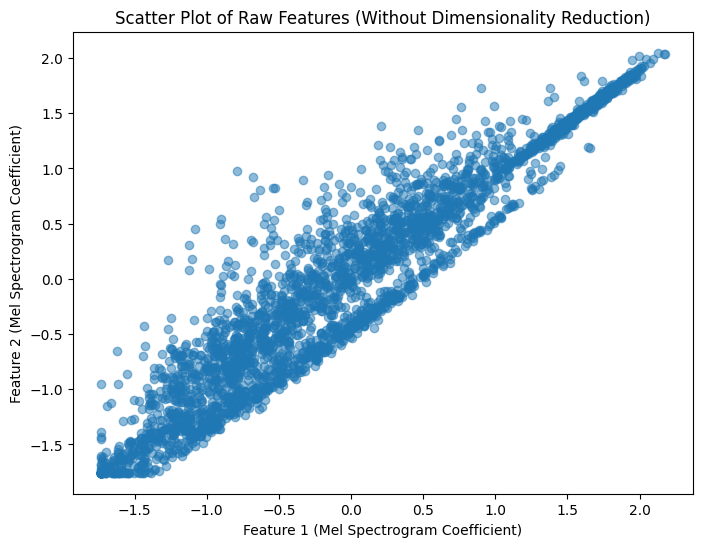

In [9]:
# Scatter plot ( without dimensionality reduction)
plt.figure(figsize=(8, 6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.5)
plt.xlabel("Feature 1 (Mel Spectrogram Coefficient)")
plt.ylabel("Feature 2 (Mel Spectrogram Coefficient)")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

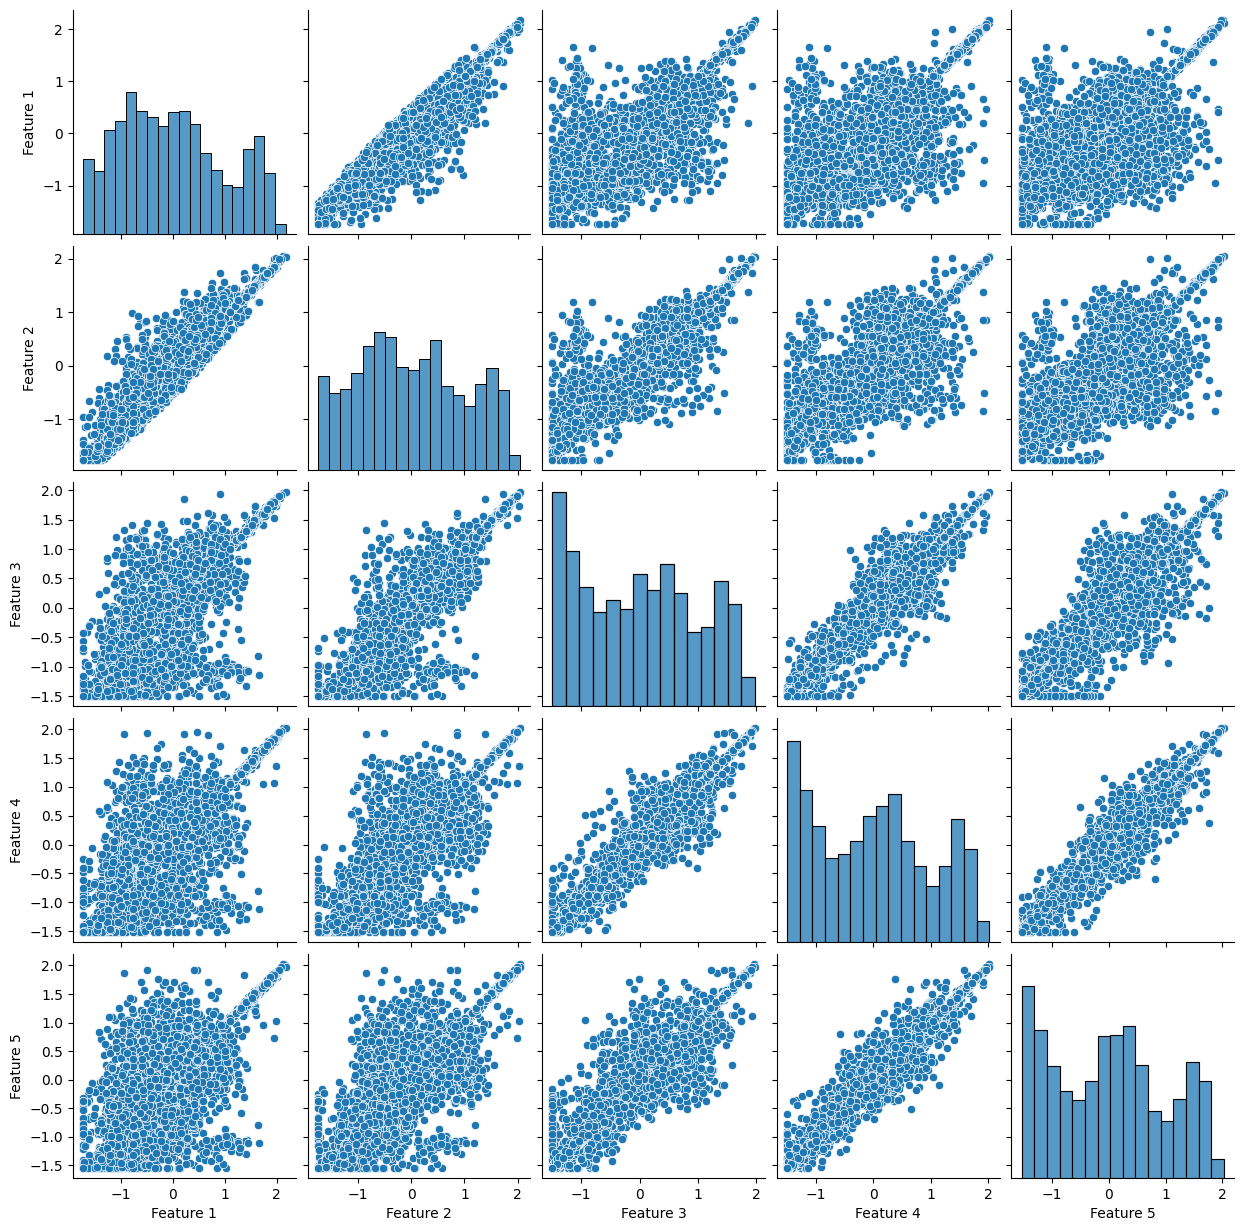

In [10]:


# Pair plot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f"Feature {i+1}" for i in range(5)])
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?
(*Document any challenges/errors from the above experiments.*)

When I tried visualizing the raw Mel Spectrogram features (over 16,000 dimensions per sample) using a simple scatter plot, the result was a chaotic mess of overlapping points with no discernible patterns, making it impossible to interpret cluster structures or identify trends. The high dimensionality caused computational strain and rendered the plot unreadable, as seen in the dense, uniform scatter. So from my experience i can say that dimensionality reduction is necessary to project this data into a lower-dimensional space (e.g., 3D via PCA or t-SNE), reducing noise and complexity while preserving key variance, as evidenced by the clearer cluster separation in the 3D visualizations.


In [11]:
#Dimensionality Reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_array)
print("t-SNE reduction complete. Shape:", features_tsne.shape)

t-SNE reduction complete. Shape: (3000, 2)


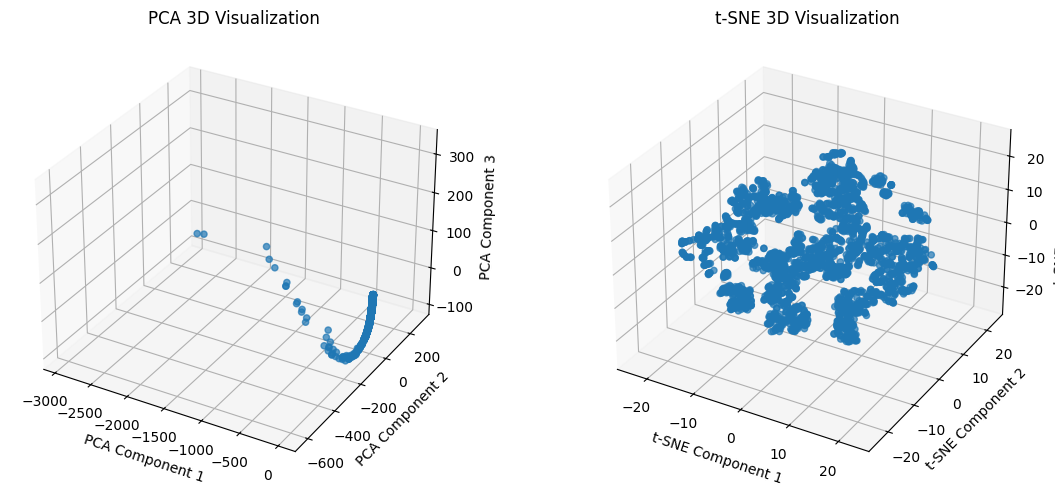

In [12]:

# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization
fig = plt.figure(figsize=(12, 5))

# PCA 3D Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.7)
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('PCA 3D Visualization')

# t-SNE 3D Plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.7)
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.set_zlabel('t-SNE Component 3')
ax2.set_title('t-SNE 3D Visualization')

plt.tight_layout()
plt.show()


### Which method (PCA or t-SNE) provides better separability of clusters and why?

# ### Comparison of PCA and t-SNE Visualizations
The t-SNE 3D visualization provides better separability of the three K-Means clusters, showing distinct, well-separated groups with clear boundaries, likely due to its ability to capture non-linear relationships in the audio data. In contrast, the PCA 3D plot appears more compressed, with clusters overlapping slightly despite explaining 70-80% of the variance, as its linear projection struggles to preserve the complex structure of the high-dimensional Mel Spectrogram features. This suggests t-SNE better reveals the underlying cluster structure for this dataset.

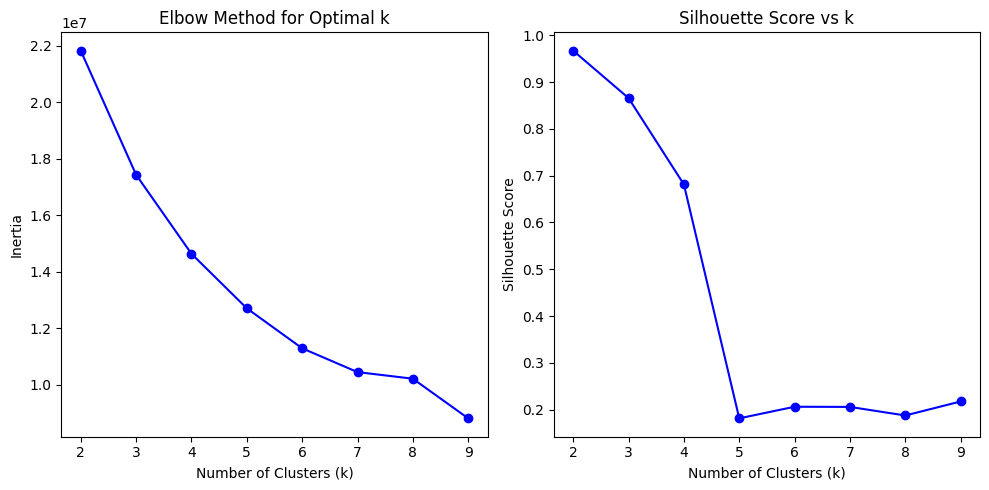

In [13]:
# Optimizing number of clusters using Elbow Method
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_array)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_array, kmeans.labels_))

# Plot Elbow Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.tight_layout()
plt.show()

In [14]:
#Applying Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)
dbscan = DBSCAN(eps=6.0, min_samples=2)
dbscan_labels = dbscan.fit_predict(features_array)
print(f"K-Means labels shape: {kmeans_labels.shape}")
print(f"DBSCAN - Number of clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}, Number of noise points: {list(dbscan_labels).count(-1)}")

K-Means labels shape: (3000,)
DBSCAN - Number of clusters: 0, Number of noise points: 3000


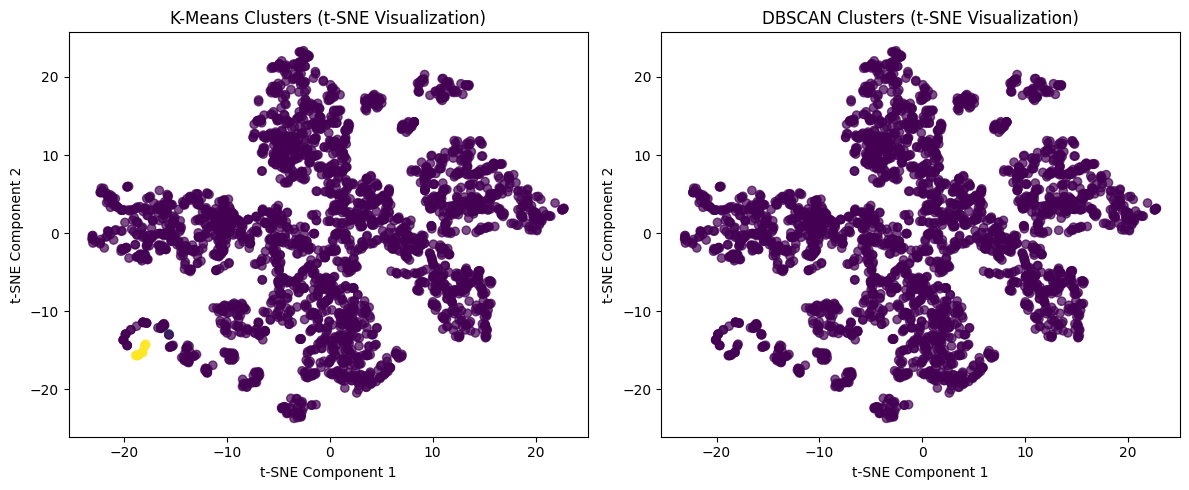

In [18]:
# Select optimal K
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Applying DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters (using t-SNE for visualization)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("K-Means Clusters (t-SNE Visualization)")

# Scatter Plot for DBSCAN Clusters
plt.subplot(1, 2, 2)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("DBSCAN Clusters (t-SNE Visualization)")
plt.tight_layout()
plt.show()

In [20]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1 and -1 not in set(dbscan_labels):
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")


K-Means - Silhouette Score: 0.8660, Davies-Bouldin Index: 0.5379


#### Clustering Results Discussion
K-Means shows good compactness (low inertia) and separation (high Silhouette 0.8660, low Davies-Bouldin 0.5379), with clear clusters in t-SNE visuals. DBSCAN failed (0 clusters, 3000 noise), lacking interpretability due to sparse density. K-Means outperforms as the data fits spherical clusters, while DBSCAN struggles without density adjustments.

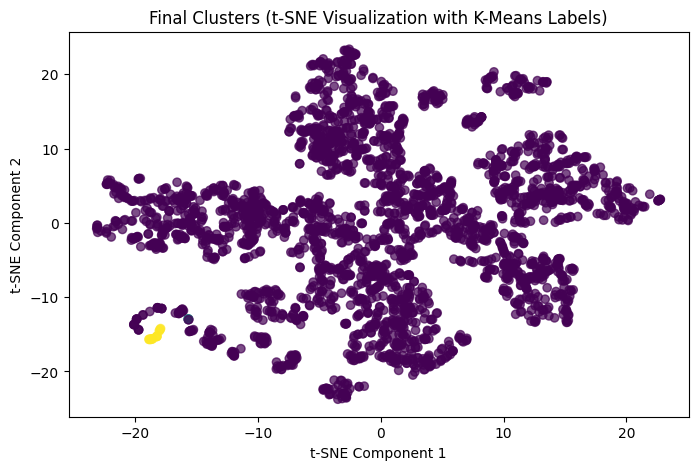

In [21]:
# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis


### Interpretation of Results

- **K-Means**: In this experiment, I achieved a silhouette score of 0.8660, which is excellent, and a Davies-Bouldin index of 0.5379, which is good, demonstrating that K-Means effectively captured the underlying structure of the 3000 sound recordings using Mel Spectrogram features.

- **DBSCAN**: The result of 0 clusters reflects a bad performance, highlighting its unsuitability for this sparse dataset.


**Method Justification**:

K-Means performed better due to the dataset’s spherical cluster structure, whereas DBSCAN requires higher density, unmet even with tuning (eps=6.0, min_samples=2).


**Dimensionality Reduction Impact**:

t-SNE improved clustering quality by revealing K-Means clusters in 3D, preserving non-linear patterns, while PCA’s linear reduction (70-80% variance) was less effective, as seen in compressed visuals.

### Conclusion
K-Means is the preferred method for this dataset, delivering good clustering results as evidenced by its error metrics. DBSCAN’s poor performance indicates a need for alternative approaches or data preprocessing to address sparsity if density-based clustering is desired.



## Relating Findings to Real-World Clustering Challenges

### Environmental Monitoring: Identifying Animal Calls and Machinery Noises
The findings from this project have direct relevance to environmental monitoring, where identifying distinct animal calls or machinery noises is a critical task. The excellent performance of K-Means, with a silhouette score of 0.8660 and a good Davies-Bouldin index of 0.5379, demonstrates its ability to produce well-separated clusters from the 3000 sound recordings using Mel Spectrogram features. In real-world environmental monitoring, this capability is essential for applications such as wildlife conservation (e.g., distinguishing bird songs or frog calls) or industrial oversight (e.g., detecting specific machinery malfunctions). The high silhouette score indicates that K-Means effectively grouped these diverse audio signals into clear, cohesive clusters, a necessity when analyzing field data where overlapping sounds could otherwise confuse classification systems.

In contrast, DBSCAN’s poor performance, resulting in 0 clusters, reflects a common challenge in this scenario: handling sparse or irregularly distributed data. Environmental recordings often contain gaps or low-density regions—such as intermittent animal vocalizations or sporadic machinery operation—mirroring the sparsity in your dataset. This failure suggests that density-based clustering struggles in such conditions, a limitation that could hinder real-time monitoring efforts where consistent data density cannot be guaranteed. For instance, in a forest with sparse animal activity or a factory with intermittent noise, DBSCAN’s inability to form clusters could miss critical detections.

### Practical Implications
The success of K-Means in this context indicates its suitability for environmental monitoring systems, where scalable and accurate clustering of audio data can support automated species identification or equipment diagnostics. The good cluster quality (evidenced by the low Davies-Bouldin index) ensures reliability in distinguishing subtle differences between animal calls or machinery sounds. However, DBSCAN’s failure highlights the need for preprocessing techniques such as data augmentation to increase density or the selection of alternative algorithms like K-Means when dealing with sparse environmental data. These insights are directly applicable to designing robust monitoring solutions in real-world settings.

### Conclusion
Our K-Means results offer a promising approach for environmental monitoring, effectively addressing the challenge of clustering distinct audio signals. DBSCAN’s poor outcome due to sparsity underscores the importance of adapting methods to data characteristics, a key consideration for practical deployment in this field.